In [1]:
#Imports
%matplotlib inline

from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fiona as fi
import folium
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import math

In [2]:
#Prepare house listings data
headers = ['latitude', 'longitude', 'postal_code','price', 'square_meter']
df = pd.read_csv('house_listings.csv', names=headers)
#https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

gdf = gdf[['postal_code', 'price', 'square_meter', 'geometry']]
gdf.head()

,postal_code,price,square_meter,geometry
0,884,16846692,114,POINT (10.77300 59.96770)
1,2067,4709380,70,POINT (11.19171 60.15454)
2,1430,5831607,73,POINT (10.79473 59.66022)
3,1406,5247648,70,POINT (10.80540 59.71681)
4,3514,5401759,130,POINT (10.34180 60.18520)


In [3]:
#Show the first 5 of the boliger til salgs data
#df.head()

In [4]:
#Checking datatypes
#df.info()

In [5]:
#Sort if you want
#df = df.sort_values(by='Pris',ascending=False)
#df.head()

<Axes: xlabel='square_meter', ylabel='price'>

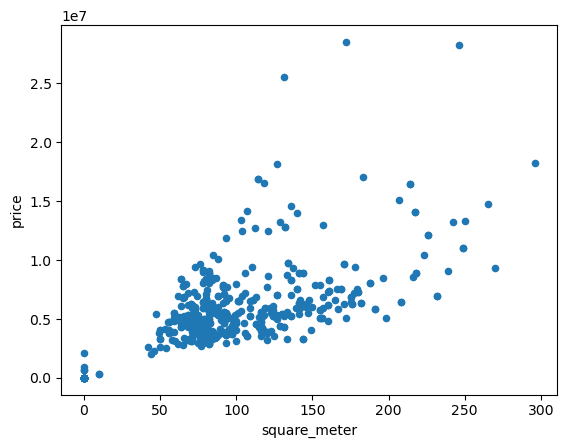

In [6]:
#Scatterplot test
df.plot.scatter(x="square_meter", y="price")

In [7]:
#Split data into for example Oslo
df2 = df[(df['postal_code'] < 1300)]
df2 = df2.reset_index()
#df3 alle utenom Oslo (tromsø)
df3 = df[(df['postal_code'] > 9005)]
df3 = df3.reset_index()

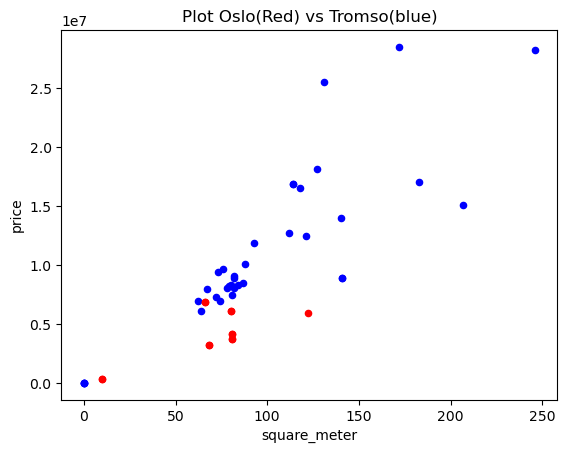

In [8]:
oslo = df2.plot.scatter(x="square_meter", y="price", color='b', title='Plot Oslo(Red) vs Tromso(blue)')
tromso = df3.plot.scatter(x='square_meter', y='price', color='r', ax=oslo)

In [9]:
#Alle
X = pd.DataFrame(df['square_meter']) #Size
y = pd.DataFrame(df['price']) #Price
#Oslo
'''X = pd.DataFrame(df2['square_meter']) #Size
y = pd.DataFrame(df2['price']) #Price
#Alle utenom Oslo'''
'''X = pd.DataFrame(df3['square_meter']) #Size
y = pd.DataFrame(df3['price']) #Price'''

sc_X=MinMaxScaler()
sc_y=MinMaxScaler()
X = sc_X.fit_transform(np.array(X))
y = sc_y.fit_transform(np.array(y))
#Now, split the set in training and testing set
#test_size = 0.33 tell the function that 1/3 of values should be put in test arrat
#Random state is a variable that seeds the random generator. In that way
#you'll get the same training and testing set each run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)



In [ ]:
#Linear regression model

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
Y_pred = lin_reg.predict(X_train)

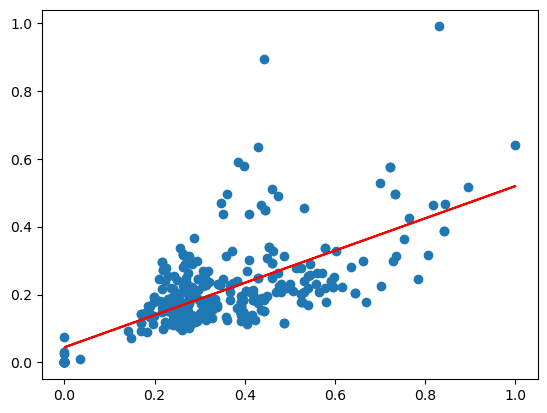

MSE = 0.009017538023369104


In [11]:
plt.scatter(X_train, y_train)
plt.plot(X_train, Y_pred, color='r')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y_train,Y_pred))) #Calculate MSE

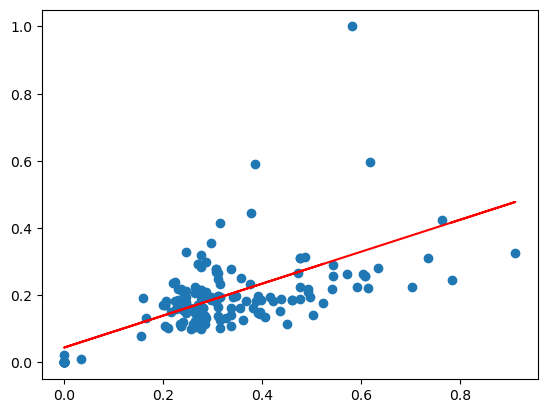

MSE = 0.008243882642340822


In [12]:
Y_pred = lin_reg.predict(X_test)  # Predict the model on X_test
plt.scatter(X_test, y_test)
plt.plot(X_test, Y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(y_test,Y_pred)))

<Axes: >

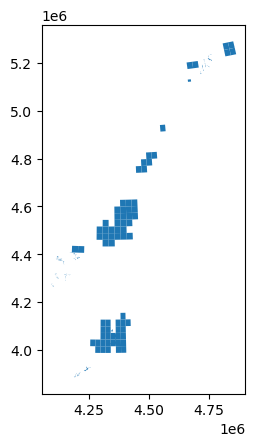

In [13]:
#Forksjellige layers hvor vi får ut forskjellige verdier
#gdf3 = gpd.read_file('flom.gml', layer='FerskvannTørrfall')
#print(fi.listlayers('flom.gml'))
#print(fi.listlayers('kvikkleire.gml'))
gdf2 = gpd.read_file('kvikkleire.gml', layer = 'KvikkleireFaresoneAvgr') #Faresone?
gdf5 = gpd.read_file('kvikkleire.gml', layer = 'Kartleggingsområde') #Kartlegging
#gdf2 = gpd.read_file('kvikkleire.gml', layer = 'UtlopOmr')
#gdf2 = gdf2[['faregrad', 'risiko','konsekvens', 'inngrep', 'risikoPoeng', 'risikoProsent','areal_km2', 'geometry']]
#gdf2 = gdf2[['skredFaregradKlasse', 'skredSkadeKonsekvensScore','skredRisikoKvikkleireKlasse', 'skredFaregradScore', 'skredSkadeKonsekvensKlasse', 'geometry']]

gdf5.plot()

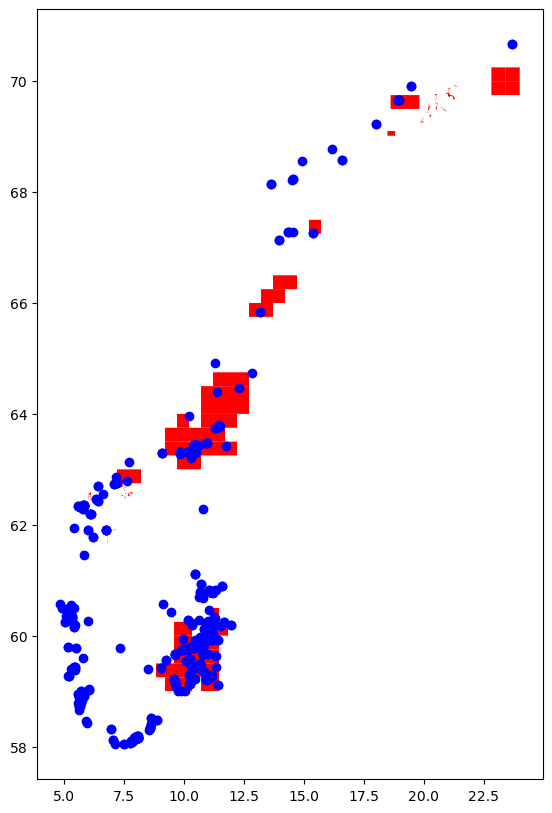

In [14]:
#må endre slik at begge bruker samme koordinatsystem.
gdf = gdf.set_crs(epsg='4326')
gdf5=gdf5.to_crs(epsg='4326')
#Plott kvikkleire områder sammen med hus til salgs på finn
kvikk = gdf5.plot(figsize=(10, 10), color='r')
hus = gdf.plot(color='b', ax=kvikk)

In [15]:
#Legger til en fareområde kolonne i tabell
gdf['inDangerArea']=False
#(POLYGON)Looper igjennom gdf og leter etter minst et område som overlapper med fareområde, setter så fareområde til True hvis så
for i in gdf.index:
    for j in gdf5.index:
        if(gdf['geometry'][i].within(gdf5['geometry'][j])):
            gdf.loc[i, ('inDangerArea')]=True
            break
#For linestring, fryktelig treg!                                   
'''for i in gdf.index:
    for j in gdf5.index:
        if(gdf5['geometry'][j].distance(gdf['geometry'][i]) < 1e-2):
            gdf.loc[i, ('inDangerArea')]=True
            break'''
#Får ikke sortert geopandas?.
gdf.sort_values(by=['postal_code'])
gdf.inDangerArea.value_counts()


inDangerArea
True     310
False    218
Name: count, dtype: int64

In [16]:
#Deler inn i fareområde og ikkefareområde, rydder også opp slik at pris og kvadratmeter er over 0
gdf_fare = gdf[gdf['inDangerArea'] == True]
gdf_fare = gdf_fare[(gdf_fare['price'] > 0)]
gdf_fare = gdf_fare[gdf_fare ['square_meter'] > 0]
gdf_fare = gdf_fare.reset_index()
#gdf_fare
gdf_trygg = gdf[gdf['inDangerArea'] == False]
gdf_trygg = gdf_trygg[gdf_trygg['price'] > 0]
gdf_trygg = gdf_trygg[gdf_trygg['square_meter'] > 0]
gdf_trygg = gdf_trygg.reset_index()
#gdf_trygg

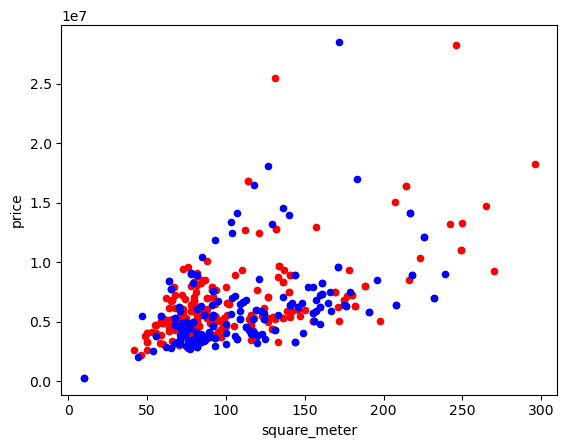

In [17]:
#Plotter slik at farlig er rød og ikke-farlig er blå
farlig = gdf_fare.plot.scatter(x="square_meter", y="price", color='r')
trygg = gdf_trygg.plot.scatter(x='square_meter', y='price', color='b', ax=farlig)




In [18]:
#Legger kvadratmeter som input og pris om output
X = pd.DataFrame(gdf_fare['square_meter']) #Size
y = pd.DataFrame(gdf_fare['price']) #Price

#Lager et test set og trene set. Treningen vil ligge på 67% av datasettet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12)

#Lager lineær regresjon og legger den over våre x og y-verdier
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
Y_pred = lin_reg.predict(X_train)

#Gjør det samme for trygge områder
X2 = pd.DataFrame(gdf_trygg['square_meter']) #Size
y2 = pd.DataFrame(gdf_trygg['price']) #Price

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=12)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_train2, y_train2)
Y_pred2 = lin_reg2.predict(X_train2)
#Y_pred2 = np.reshape(Y_pred2, (-1,1))


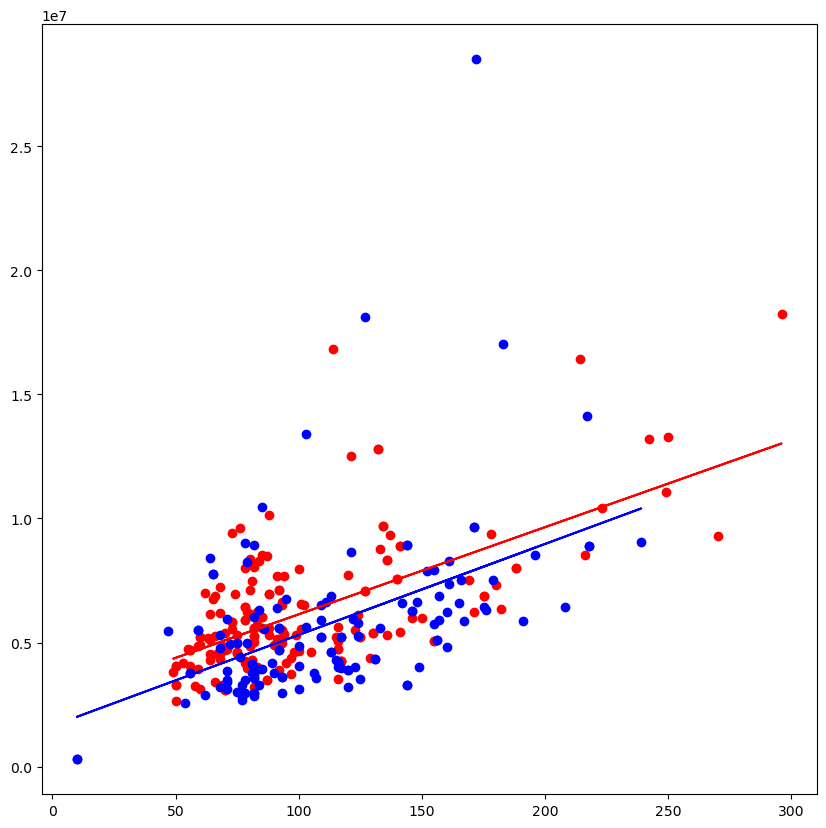

MSE fare  = 3855567095355.875
MSE trygg = 8490223024233.553


In [19]:
#Plotter trygg og farlig og lager lineær regresjon for begge, rød=farlig blå=trygg
plt.figure(figsize=(10,10))
plt.scatter(X_train, y_train, color='r')
plt.scatter(X_train2, y_train2, color='b')
plt.plot(X_train, Y_pred, color='r')
plt.plot(X_train2, Y_pred2, color='b')

plt.show()
#Printer ut median feil^2
print( "MSE fare  = "+str(metrics.mean_squared_error(y_train,Y_pred))) #Calculate MSE
print( "MSE trygg = "+str(metrics.mean_squared_error(y_train2,Y_pred2))) #Calculate MSE

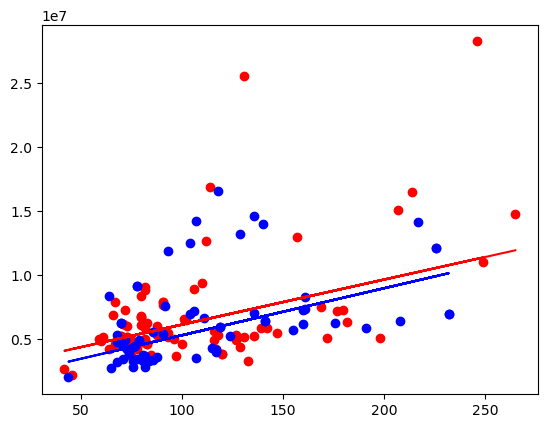

MSE fare  = 12449258891465.543
MSE trygg = 9739002133798.39


In [20]:
#Her gjør vi det med test settet vårt.
Y_pred = lin_reg.predict(X_test)  # Predict the model on X_test
Y_pred2 = lin_reg2.predict(X_test2)  # Predict the model on X_test

plt.scatter(X_test, y_test, color='red')
plt.scatter(X_test2, y_test2, color='blue')

plt.plot(X_test, Y_pred, color='red')
plt.plot(X_test2, Y_pred2, color='blue')
plt.show()
print( "MSE fare  = "+str(metrics.mean_squared_error(y_test,Y_pred)))
print( "MSE trygg = "+str(metrics.mean_squared_error(y_test2,Y_pred2)))